<a id="setup"></a>
# ⚙️ Setup

In [1]:
#Import necessary Libraries

import os
import warnings
import tensorflow as tf
import seaborn as sns
import random
import numpy as np
from tensorflow.keras.callbacks import Callback
from keras import models, layers
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Ignore warnings

warnings.filterwarnings("ignore")

# Set Seed

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define Dataset Paths

train_path = 'Training'
test_path = 'Testing'

2025-08-24 22:59:39.300448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756076379.541861    3245 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756076379.599635    3245 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="Load"></a>
# 📂 Data Preperation

In [2]:
# Load Dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(299,299),
    batch_size=32,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(299,299),
    batch_size=32,
    shuffle=True,
    seed=SEED
)

# Augment Dataset

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

data_augmentation_2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_train_ds_2 = train_ds.map(lambda x, y: (data_augmentation_2(x, training=True), y))

# Combine original + augmented

train_ds = train_ds.concatenate(augmented_train_ds)
train_ds = train_ds.concatenate(augmented_train_ds_2)

Found 5712 files belonging to 4 classes.


I0000 00:00:1756076389.712479    3245 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1311 files belonging to 4 classes.


<a id="Conversion"></a>
# 🔄 Data Conversion, Normalization, and Splitting

In [3]:
# Convert to grayscale and normalize data

def dataset_to_numpy(dataset):
    x, y = [], []
    for images, labels in dataset:
        images = tf.image.rgb_to_grayscale(images)
        images = tf.cast(images, tf.float32) / 255.0
        x.append(images.numpy())
        y.append(labels.numpy())
    return np.concatenate(x), np.concatenate(y)

x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test   = dataset_to_numpy(test_ds)

y_train = to_categorical(y_train, num_classes=4)
y_test  = to_categorical(y_test, num_classes=4)

# Split train into (train + validation)

x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=SEED
)

<a id=" Model classes"></a>
# 🧩 Define Model Classes

In [4]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

<a id="Model"></a>
# 🏗️ Model Architecture

In [5]:
def create_model(input_shape):
    model = models.Sequential()

    # Convolutional layer 1
    model.add(layers.Conv2D(64, (5,5), activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3,3)))
    model.add(layers.Dropout(0.2))

    # Convolutional layer 2
    model.add(layers.Conv2D(64, (5,5), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(3,3)))
    model.add(layers.Dropout(0.2))

    # Convolutional layer 3
    model.add(layers.Conv2D(128, (4,4), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    # Convolutional layer 4
    model.add(layers.Conv2D(128, (4,4), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))
    

    # Flatten
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.Dropout(0.6))   
    model.add(layers.Dense(4, activation="softmax"))

    # Compile model with Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


    return model

<a id="Dual"></a>
# 🔀 DualMetricCheckpoint Class

In [6]:
# Class that saves the best model based on validation accuracy, then validation loss

class DualMetricCheckpoint(Callback):
    def __init__(self, filepath):
        super(DualMetricCheckpoint, self).__init__()
        self.filepath = filepath
        self.best_acc = -np.Inf
        self.best_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        val_loss = logs.get("val_loss")

        # If accuracy improves or (same acc within 1e-4 AND lower loss), save the model
        if (val_acc > self.best_acc) or \
           (np.isclose(val_acc, self.best_acc, atol=1e-4) and val_loss < self.best_loss):
            
            print(f"\nEpoch {epoch+1}: val_accuracy={val_acc:.4f}, val_loss={val_loss:.4f} "
                  f"--> saving best model")
            
            self.best_acc = val_acc
            self.best_loss = val_loss
            self.model.save(self.filepath)

<a id="Training"></a>
# 📈 Training

In [7]:
# Train with checkpoint to save the best model

checkpoint = DualMetricCheckpoint("best_model.h5")

# Create the model

input_shape = x_train_new.shape[1:]
model = create_model(input_shape)

# Train the model

history = model.fit(
    x_train_new, y_train_new,
    epochs=55,
    batch_size=32,
    verbose=1,
    validation_data=(x_val, y_val),   
    callbacks=[checkpoint]
)

Epoch 1/55


2025-08-24 23:05:46.833301: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
E0000 00:00:1756076750.071228    3245 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1756

429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5510 - loss: 1.1654

2025-08-24 23:06:57.927703: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 1: val_accuracy=0.6960, val_loss=0.8920 --> saving best model
429/429 ━━━━━━━━━━━━━━━━━━━━ 78s 158ms/step - accuracy: 0.5513 - loss: 1.1649 - val_accuracy: 0.6960 - val_loss: 0.8920
Epoch 2/55
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8055 - loss: 0.7669
Epoch 2: val_accuracy=0.8404, val_loss=0.7006 --> saving best model
429/429 ━━━━━━━━━━━━━━━━━━━━ 63s 148ms/step - accuracy: 0.8056 - loss: 0.7669 - val_accuracy: 0.8404 - val_loss: 0.7006
Epoch 3/55
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8861 - loss: 0.6461
Epoch 3: val_accuracy=0.8973, val_loss=0.6026 --> saving best model
429/429 ━━━━━━━━━━━━━━━━━━━━ 63s 147ms/step - accuracy: 0.8861 - loss: 0.6461 - val_accuracy: 0.8973 - val_loss: 0.6026
Epoch 4/55
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9110 - loss: 0.6034
Epoch 4: val_accuracy=0.9233, val_loss=0.5844 --> saving best model
429/429 ━━━━━━━━━━━━━━━━━━━━ 63s 148ms/step - accuracy: 0.9110 - loss: 0.6034 - val_accuracy: 0.9233 - 

<a id="Evaluation"></a>
# 🧪 Evaluation

In [28]:
# Load best saved model

model.load_weights("best_model.h5")

# Evaluate the model

train_loss_best, train_acc_best = model.evaluate(x_train, y_train, verbose=0)
val_loss_best, val_acc_best = model.evaluate(x_val, y_val, verbose=0)
test_loss_best, test_acc_best = model.evaluate(x_test, y_test, verbose=0)

# Display accuracies and losses

print("\n=== Best Model Evaluation ===\n")
print(f"Train Accuracy:       {train_acc_best:.4f}   | Training loss:    {train_loss_best:.4}")
print(f"Validation Accuracy:  {val_acc_best:.4f}   | Validation loss:  {val_loss_best:.4}")
print(f"Test Accuracy:        {test_acc_best:.4f}   | Test loss:        {test_loss_best:.4}")

2025-08-25 00:26:42.889047: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-25 00:26:56.405921: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


=== Best Model Evaluation ===

Train Accuracy:       0.9980   | Training loss:    0.3874
Validation Accuracy:  0.9907   | Validation loss:  0.4057
Test Accuracy:        0.9931   | Test loss:        0.4016


<a id="Report"></a>
# 📑 Classification Report

In [9]:
# Convert one-hot encoded labels to class indices

y_true = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class indices

y_pred = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

# Generate classification report

report = classification_report(y_true, y_pred, target_names=class_names)
print("\n\n=== Classification Report ===\n\n")
print(report)

2025-08-25 00:04:18.710080: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}




=== Classification Report ===


              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      0.98      0.99       306
     notumor       0.99      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



<a id="confusion matrix"></a>
# 🧮 Confusion Matrix

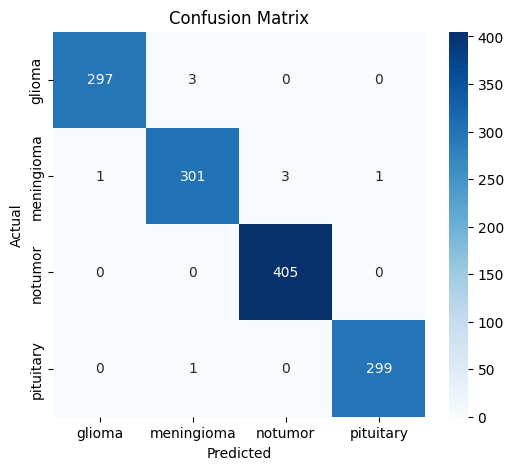

In [10]:
# Display Confusion matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<a id="predictions"></a>
# 🎯 Sample Predictions


=== Sample Predictions (with images) ===




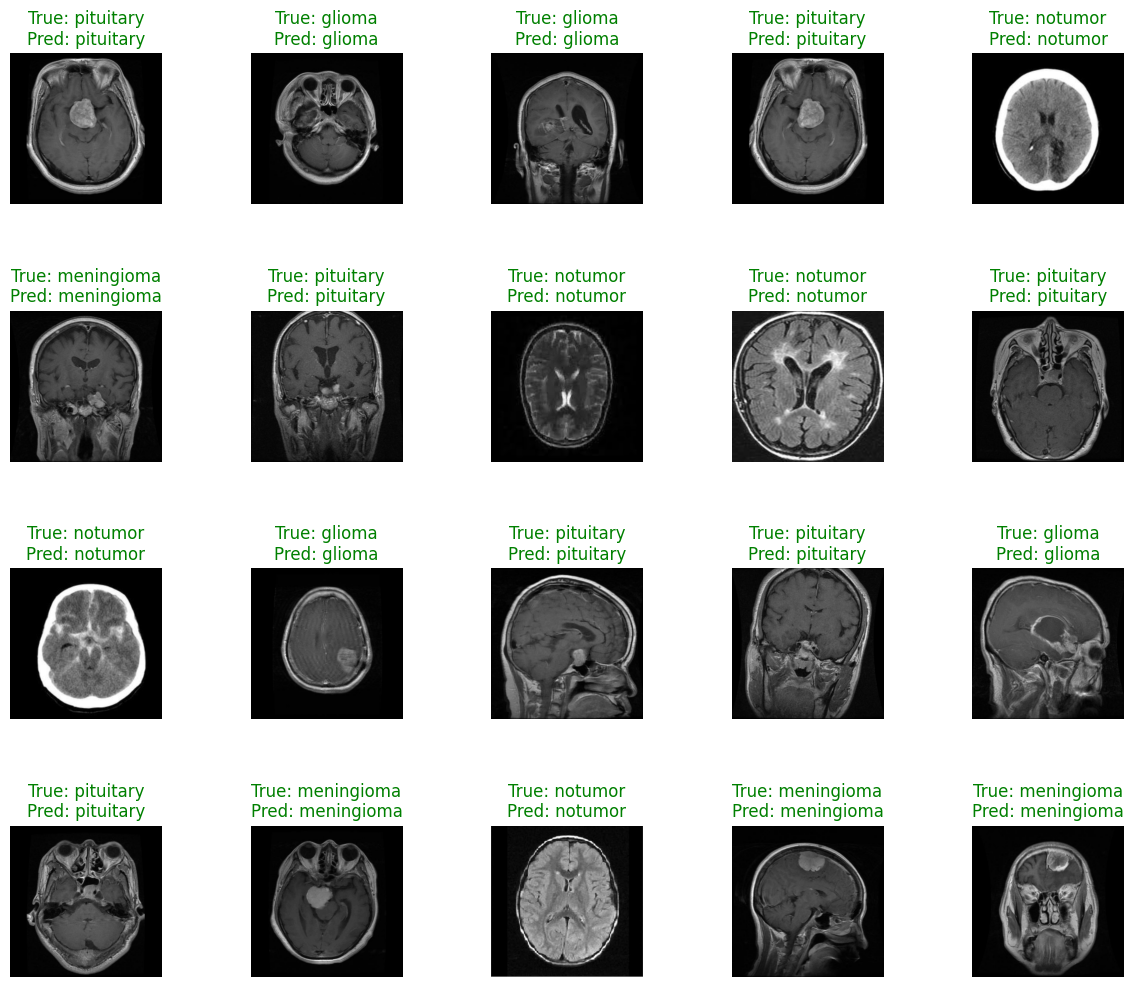

In [11]:
# Display 20 Sample predictions with images

print("\n=== Sample Predictions (with images) ===\n\n")
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.subplots_adjust(hspace=0.7)  

for i, ax in enumerate(axes.flat):
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]
    img = x_test[i].squeeze()
    color = "green" if true_label == pred_label else "red"
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=12,color=color)
    ax.axis("off")

plt.show()

<a id="visulaiztion"></a>
# 📊 Visualization

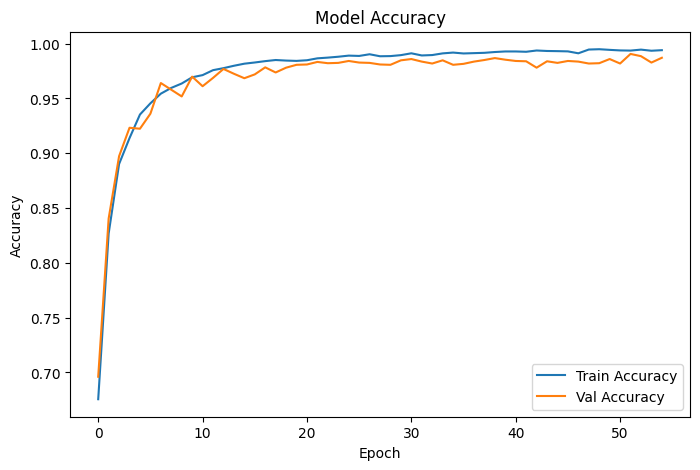

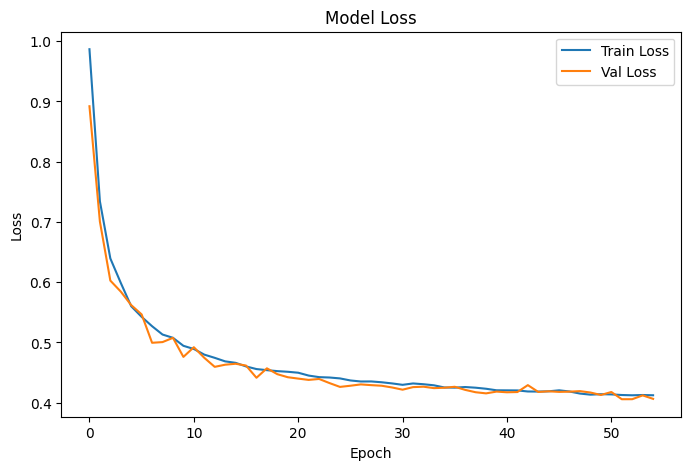

In [12]:
# Display Accuracies graph

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Display Losses graph

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()